In [ ]:
!pip install kaggle  

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download potamitis/wingbeats

In [ ]:
! unzip wingbeats.zip

In [ ]:
rm -rf /content/Wingbeats/Wingbeats

In [ ]:
from __future__ import division
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy import signal
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import librosa
import xgboost

In [ ]:
target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

X = [] # will hold PSDs of the recs
X_names = [] # will hold the full path and the filename of all recs
y = [] # the labels
target_count = []

for i, target in enumerate(target_names):
    target_count.append(0)
    #path = './Wingbeats/' + target + '/'
    path = '/content/Wingbeats/' + target + '/'
    for [root, dirs, files] in os.walk(path, topdown = False):
        for filename in files:
            name,ext = os.path.splitext(filename)
            if ext == '.wav':
                name = os.path.join(root, filename)
                data, fs = librosa.load(name, sr = 8000)
                y.append(i)
                X.append([10*np.log10(signal.welch(data, fs=fs, window='hanning', nperseg=256, noverlap=128+64)[1])])
                X_names.append(name)
                target_count[i]+=1


In [ ]:
print ('total #recs = ', len(y))

In [ ]:
names = pd.DataFrame(X_names, columns=['name'])

In [ ]:
names['name'][0]

'/content/Wingbeats/Ae. aegypti/D_17_02_08_11_00_29/F170208_110038_051_G_050.wav'

In [ ]:
PSDs = pd.DataFrame(X, columns=['PSD'])

In [ ]:
PSDs['PSD'][0].shape

(129,)

In [ ]:
df = pd.concat([names, PSDs], axis = 1)

In [ ]:
df.head()

,name,PSD
0,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-85.99616, -77.721954, -82.98425, -87.13138, ..."
1,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-81.04077, -72.61083, -81.521454, -92.88978, ..."
2,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-93.116, -83.8792, -92.783035, -96.71205, -99..."
3,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-89.47472, -77.541374, -87.73845, -95.40252, ..."
4,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-80.26874, -70.14137, -80.56443, -92.83192, -..."


In [ ]:
df['filename'] = df['name'].str.extract('([F]\w{0,})',expand=True)

In [ ]:
df.head()

,name,PSD,filename
0,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-85.99616, -77.721954, -82.98425, -87.13138, ...",F170208_110038_051_G_050
1,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-81.04077, -72.61083, -81.521454, -92.88978, ...",F170208_110029_049_G_050
2,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-93.116, -83.8792, -92.783035, -96.71205, -99...",F170208_110037_050_G_050
3,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-89.47472, -77.541374, -87.73845, -95.40252, ...",F170208_110028_048_G_050
4,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-80.26874, -70.14137, -80.56443, -92.83192, -...",F170208_110104_053_G_050


In [ ]:
print(df['filename'][0])
print(df['name'][0])

F170208_110038_051_G_050
/content/Wingbeats/Ae. aegypti/D_17_02_08_11_00_29/F170208_110038_051_G_050.wav


In [ ]:
df['species'] = df['name'].str.split('/').str.get(3)

In [ ]:
len(df['species'].unique())

6

In [ ]:
df['hour'] = df.filename.str.extract('([_]\w{0,2})',expand=True)

In [ ]:
df['hour']

0         _11
1         _11
2         _11
3         _11
4         _11
         ... 
279561    _20
279562    _20
279563    _20
279564    _20
279565    _20
Name: hour, Length: 279566, dtype: object

In [ ]:
df['hour'][0]

'_11'

In [ ]:
df['hour'] = df.hour.str.split('_',expand=True)[1].astype(int)

In [ ]:
df['hour']

0         11
1         11
2         11
3         11
4         11
          ..
279561    20
279562    20
279563    20
279564    20
279565    20
Name: hour, Length: 279566, dtype: int64

In [ ]:
df

,name,PSD,filename,species,hour
0,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-85.99616, -77.721954, -82.98425, -87.13138, ...",F170208_110038_051_G_050,Ae. aegypti,11
1,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-81.04077, -72.61083, -81.521454, -92.88978, ...",F170208_110029_049_G_050,Ae. aegypti,11
2,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-93.116, -83.8792, -92.783035, -96.71205, -99...",F170208_110037_050_G_050,Ae. aegypti,11
3,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-89.47472, -77.541374, -87.73845, -95.40252, ...",F170208_110028_048_G_050,Ae. aegypti,11
4,/content/Wingbeats/Ae. aegypti/D_17_02_08_11_0...,"[-80.26874, -70.14137, -80.56443, -92.83192, -...",F170208_110104_053_G_050,Ae. aegypti,11
...,...,...,...,...,...
279561,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-83.49184, -75.00504, -83.56732, -93.93991, -...",F161219_201055_182_G_050,C. quinquefasciatus,20
279562,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-82.03912, -73.341354, -78.41115, -83.51567, ...",F161219_201025_155_G_050,C. quinquefasciatus,20
279563,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-87.51643, -78.559044, -81.81012, -84.3884, -...",F161219_201209_235_G_050,C. quinquefasciatus,20
279564,/content/Wingbeats/C. quinquefasciatus/D_16_12...,"[-75.800156, -67.49843, -75.84076, -82.94593, ...",F161219_201042_173_G_050,C. quinquefasciatus,20


In [ ]:
df1 = df[['species','hour']]

In [ ]:
df1

,species,hour
0,Ae. aegypti,11
1,Ae. aegypti,11
2,Ae. aegypti,11
3,Ae. aegypti,11
4,Ae. aegypti,11
...,...,...
279561,C. quinquefasciatus,20
279562,C. quinquefasciatus,20
279563,C. quinquefasciatus,20
279564,C. quinquefasciatus,20


species
Ae. aegypti            AxesSubplot(0.125,0.125;0.775x0.755)
Ae. albopictus         AxesSubplot(0.125,0.125;0.775x0.755)
An. arabiensis         AxesSubplot(0.125,0.125;0.775x0.755)
An. gambiae            AxesSubplot(0.125,0.125;0.775x0.755)
C. pipiens             AxesSubplot(0.125,0.125;0.775x0.755)
C. quinquefasciatus    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

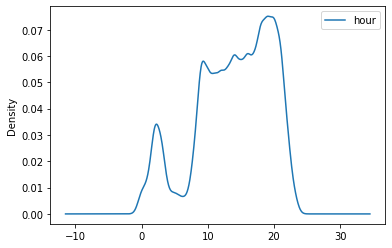

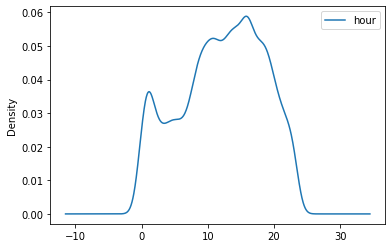

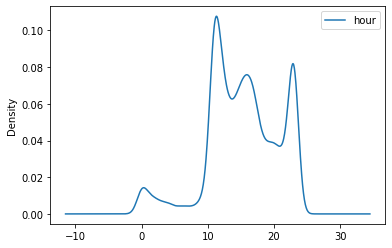

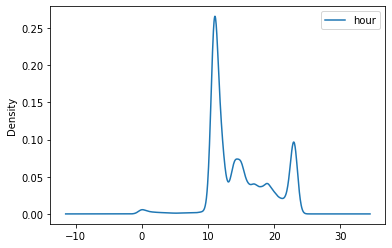

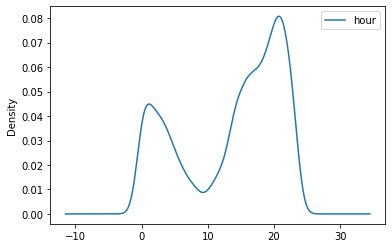

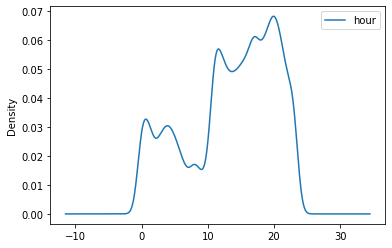

In [ ]:
df1.groupby('species').plot.kde()

In [ ]:
df1 = df[['species','hour']]
df1.groupby('species').plot.kde(xlim=(0,23))
plt.show()
df1.groupby('species').describe()

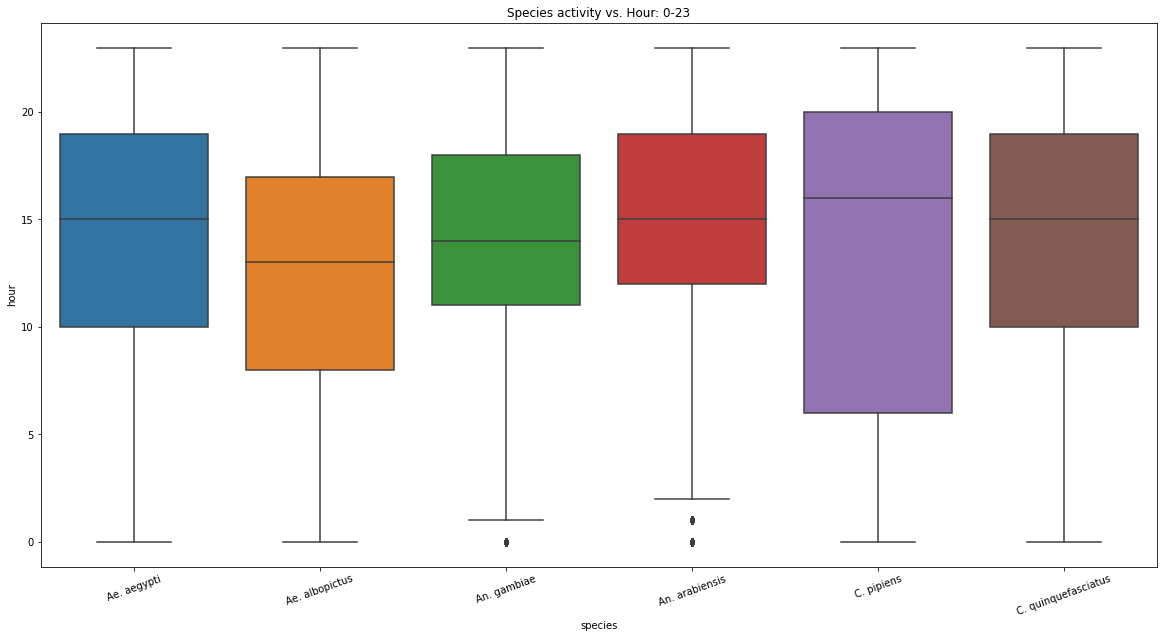

In [ ]:
plt.figure(figsize=(20,10))
g = sns.boxplot(x="species", y="hour",data=df1)
g.set_xticklabels(g.get_xticklabels(),rotation=20)
plt.title('Species activity vs. Hour: 0-23')
plt.show() 

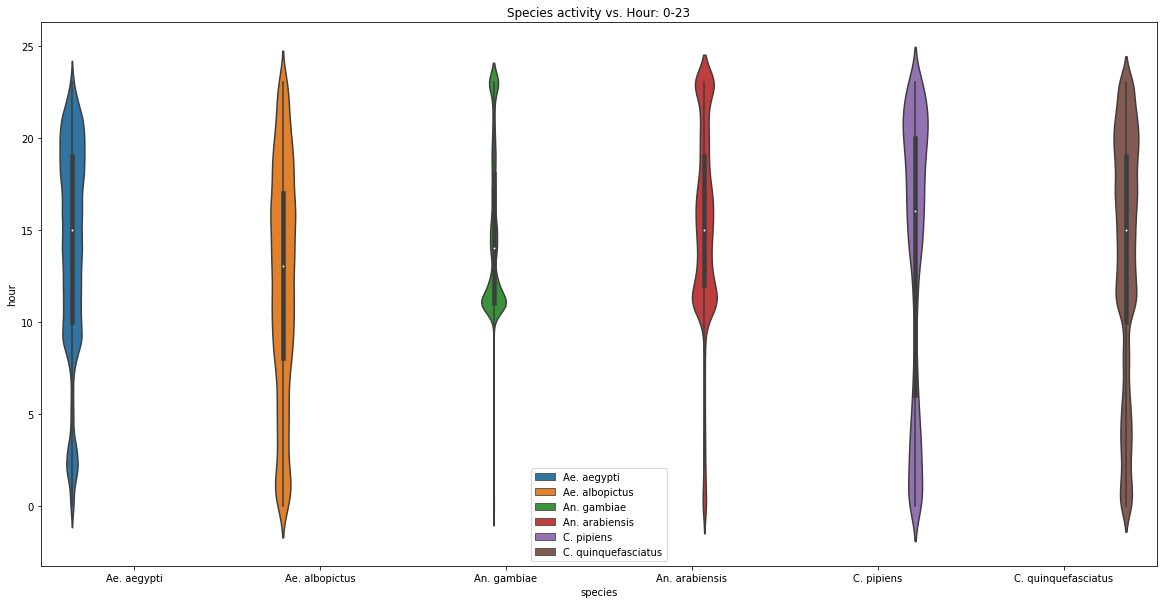

In [ ]:
plt.figure(figsize=(20,10))
g = sns.violinplot(x="species", y="hour", data=df1, hue = 'species');
plt.legend(loc = 'lower center')
plt.title('Species activity vs. Hour: 0-23')
plt.show()